# USPEX prism point-source reduction example

Last updated 24 May 2023

This notebook demonstrates the reduction of a USPEX prism point-source data using the test data provided with the code in test_data/uspex-prism

## Steps:
* setup instrument parameters (WORKING)
* reduce calibration data (WORKING)
* extract science point source (WORKING)
* extract telluric standard point source (WORKING)
* combine individual science spectra into one spectrum (WORKING)
* combine individual telluric spectra into one spectrum (WORKING)
* telluric calibration science spectrum (TBD)


In [1]:
# import package and check
import pyspextool as ps
import os
import numpy as np
import matplotlib.pyplot as pl

help(ps)

Help on package pyspextool:

NAME
    pyspextool

DESCRIPTION
    PySpexTool is a package intended to contain core functionality and some
    common tools needed for performing reduction for SpeX instrument in
    Python.

PACKAGE CONTENTS
    combine (package)
    config
    extract (package)
    fit (package)
    io (package)
    plot (package)
    setup_utils
    utils (package)

FILE
    /Users/adam/python_codes/pyspextool/src/pyspextool/__init__.py




## Setup

In [2]:
# what instrument and mode we are using
instrument = 'uspex'
mode = 'prism'

# point to test data folder for USPEX prism data
# NOTE: this should be moved internally
pfolder = os.path.dirname(os.path.abspath(ps.__file__))+'/../../'
tdfolder = pfolder+'/test_data/{}-{}/'.format(instrument,mode)
#tdfolder = '/Users/adam/python_codes/pyspextool/test_data/{}-{}/'.format(instrument,mode)

# set output pathways
redux_folder = '/Users/adam/projects/spex_archive/test_uspex-prism/'
raw_path = tdfolder
cal_path = redux_folder+'/cals/'
proc_path = redux_folder+'/proc/'
qa_path = redux_folder+'/cals/'

# file prefixes
src_prefix = 'sbd.2022B046.221019.spc.'
flat_prefix = 'sbd.2022B046.221019.flat.'
arc_prefix = 'sbd.2022B046.221019.arc.'

# file numbers
flat_files = '15-19'
arc_files = '20'
src_files = '1-2'
tell_files = '7-8'

# extraction details
orders = '1' # orders to extract
source_type = 'ps' # source type: 'ps' (default) or 'xs'
reduction_mode = 'A-B' # reduction mode: 'A-B' (default), 'A', 'A-Sky/Dark'
npos = 2
aperture_positions = [3.7, 11.2] # preset aperture positions
aperture_method = 'auto' # method to identify aperture: 'fixed', 'guess', or 'auto' (default)
ps_aperture = 1.5 # preset aperture width for point source in multiples of PSF radius
psf_radius = 1.5 # point source PSF radius
ps_bg_parameters = [2.5,4] # point source background parameters; radius to start, then width
combine_prefix = 'combspec'
scale_range = '1.0-1.3'

# set up instrument
ps.pyspextool_setup(instrument,raw_path=raw_path, cal_path=cal_path, proc_path=proc_path, 
                    qa_path=qa_path,verbose=True)



Pyspextool Setup
----------------
Instrument:  uspex

Rawpath:  /Users/adam/python_codes/pyspextool/test_data/uspex-prism
Calpath:  /Users/adam/projects/spex_archive/test_uspex-prism/cals
Procpath:  /Users/adam/projects/spex_archive/test_uspex-prism/proc
Qapath:  /Users/adam/projects/spex_archive/test_uspex-prism/cals

QA Extension: .pdf
QA Plot: False
QA File: True 



## Calibrations

Generating Flat Field
---------------------
Loading images...
100% |**********************************************************************|
Scaling images...
Medianing the images...
Locating the orders...
Normalizing the median image...
Normalizing the flat...
100% |**********************************************************************|
Writing flat to disk...
Flat field flat15-19.fits written to disk.

Generating Wavelength Solution
------------------------------
Loading images...
100% |**********************************************************************|
Extracting 1 apertures in 1 orders (without background subtraction)...
100% |**********************************************************************|


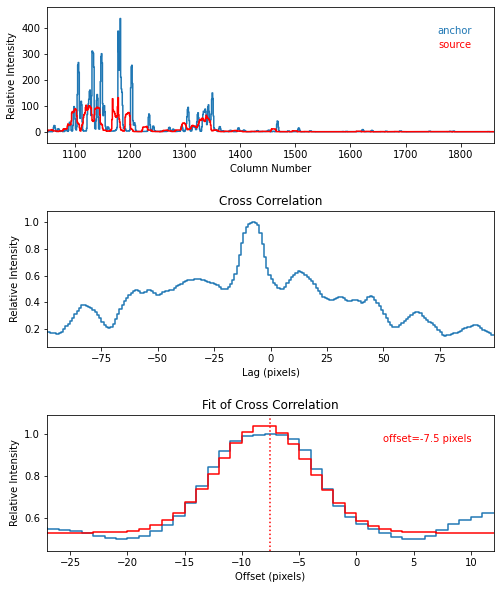

Using stored solution...
Writing wavecal to disk...
Wavecal wavecal20.fits written to disk.



In [3]:
# conduct calibrations
ps.extract.make_flat([flat_prefix,flat_files],'flat{}'.format(flat_files),qa_file=True,verbose=True)

# note: use stored solution unless slit width = 0.3
ps.extract.make_wavecal([arc_prefix,arc_files],'flat{}.fits'.format(flat_files),'wavecal{}'.format(arc_files),\
    qa_file=True,qa_plot=True,use_stored_solution=True,verbose=True)


## Extract science files

Loading the flat...
Loading the wavecal...
Loading sbd.2022B046.221019.spc.00001.a.fits, sbd.2022B046.221019.spc.00002.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Setting extraction type to point source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 1 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00001 to disk.


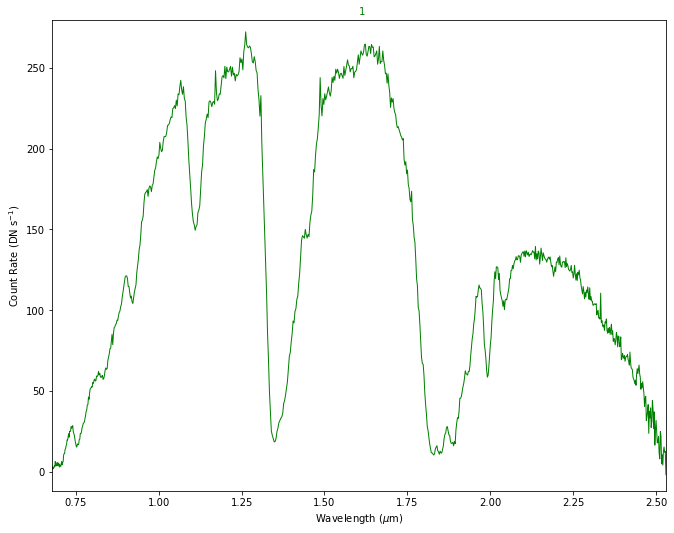

Wrote spectra00002 to disk.


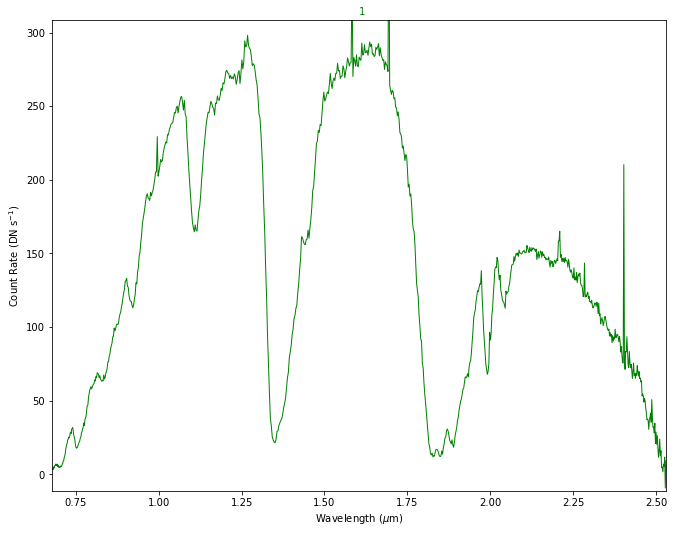

 
Loading sbd.2022B046.221019.spc.00001.a.fits, sbd.2022B046.221019.spc.00002.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 1 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00001 to disk.


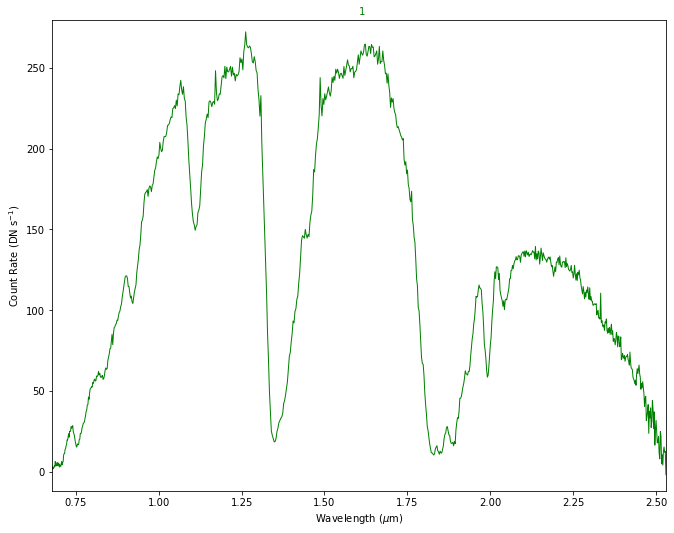

Wrote spectra00002 to disk.


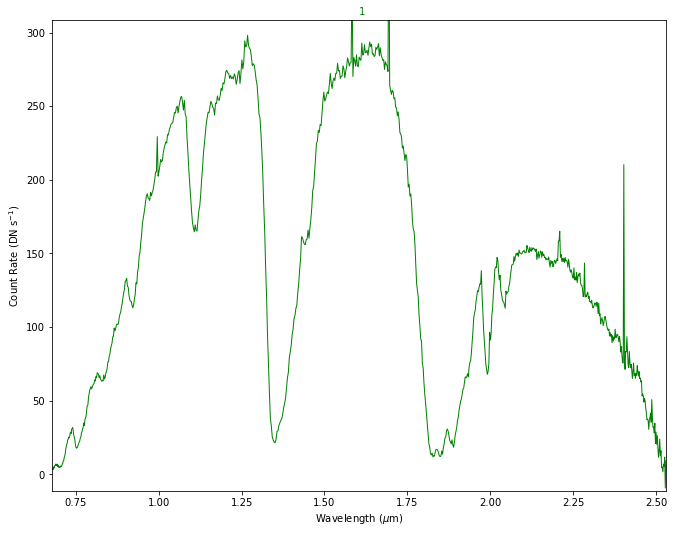

 
Do All Steps Complete.


In [4]:
# extract first two images of science target

# load in images and apply flat and wavecal calbrations
ps.extract.load_image([src_prefix,ps.io.files.extract_filestring(src_files,method='index')[:2]],\
                      'flat{}.fits'.format(flat_files), 'wavecal{}.fits'.format(arc_files),\
                      flat_field=True, linearity_correction=True,reduction_mode=reduction_mode, \
                      qa_plot=False, qa_file=True, verbose=True)

# set extraction method to point source
ps.extract.set_extraction_type(source_type)

# make spatial profiles
ps.extract.make_spatial_profiles(qa_plot=False, qa_file=False, verbose=True)

# identify aperture positions (set above)
if aperture_method=='auto': # this works for method = 'auto'
    ps.extract.locate_aperture_positions(2, method=aperture_method, qa_plot=False, qa_file=False, verbose=True)
else:
    ps.extract.locate_aperture_positions(aperture_positions, method=aperture_method, qa_plot=False, qa_file=False, verbose=True)

# select orders to extract (set above)
ps.extract.select_orders(include=orders, qa_plot=False, qa_file=False, verbose=True)

# trace apertures
ps.extract.trace_apertures(qa_plot=False, qa_file=True, verbose=True)

# define the aperture - psf, width, background
ps.extract.define_aperture_parameters(ps_aperture, psf_radius=psf_radius,bg_radius=ps_bg_parameters[0],\
                        bg_width=ps_bg_parameters[1], qa_plot=False, qa_file=True)

# extract away
ps.extract.extract_apertures(verbose=True)

# conduct extraction of all remaining files
# NOTE: this is redundant for the first two files,
# and also unnecessary here because we only have 2 files!
ps.extract.do_all_steps([src_prefix,src_files])


## Extract telluric/flux cal spectrum

Loading the flat...
Loading the wavecal...
Loading sbd.2022B046.221019.spc.00007.a.fits, sbd.2022B046.221019.spc.00008.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Setting extraction type to point source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 1 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00007 to disk.


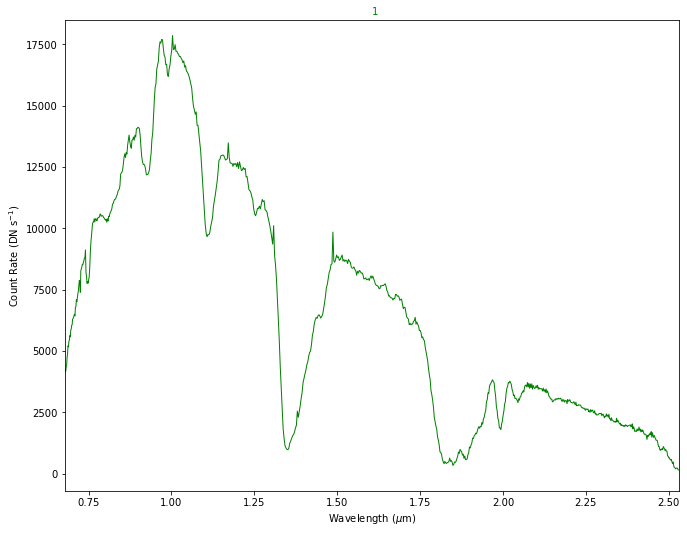

Wrote spectra00008 to disk.


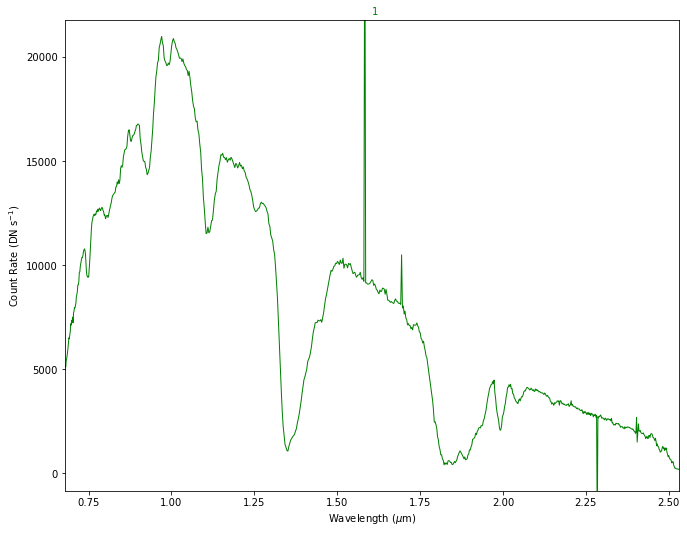

 
Loading sbd.2022B046.221019.spc.00007.a.fits, sbd.2022B046.221019.spc.00008.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 1 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00007 to disk.


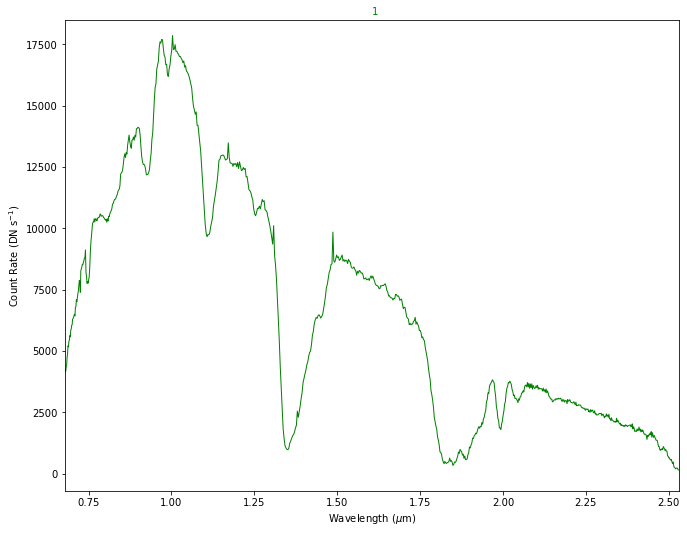

Wrote spectra00008 to disk.


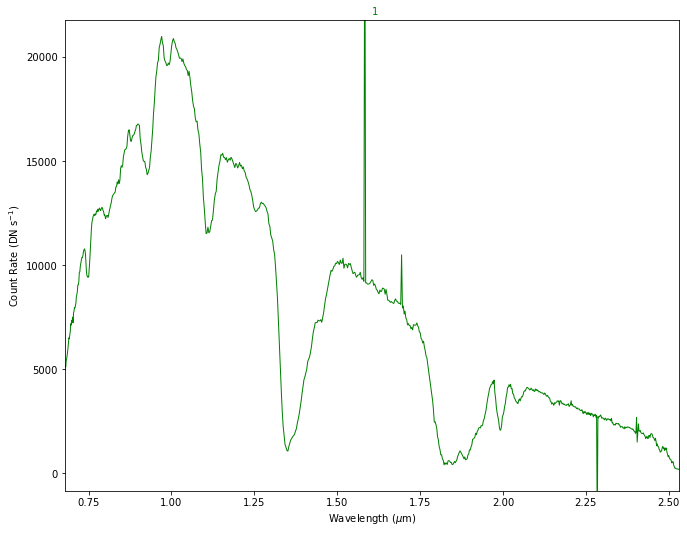

 
Do All Steps Complete.


In [5]:
# now do telluric source

# load in images and apply flat and wavecal calbrations
ps.extract.load_image([src_prefix,ps.io.files.extract_filestring(tell_files,method='index')[:2]],\
                      'flat{}.fits'.format(flat_files), 'wavecal{}.fits'.format(arc_files),\
                      flat_field=True, linearity_correction=True,reduction_mode=reduction_mode, \
                      qa_plot=False, qa_file=True, verbose=True)

# set extraction method to point source
ps.extract.set_extraction_type(source_type)

# make spatial profiles
ps.extract.make_spatial_profiles(qa_plot=False, qa_file=False, verbose=True)

# identify aperture positions (set above)
if aperture_method=='auto': # this works for method = 'auto'
    ps.extract.locate_aperture_positions(2, method=aperture_method, qa_plot=False, qa_file=False, verbose=True)
else:
    ps.extract.locate_aperture_positions(aperture_positions, method=aperture_method, qa_plot=False, qa_file=False, verbose=True)

# select orders to extract (set above)
ps.extract.select_orders(include=orders, qa_plot=False, qa_file=False, verbose=True)

# trace apertures
ps.extract.trace_apertures(qa_plot=False, qa_file=True, verbose=True)

# define the aperture - psf, width, background
ps.extract.define_aperture_parameters(ps_aperture, psf_radius=psf_radius,bg_radius=ps_bg_parameters[0],\
                        bg_width=ps_bg_parameters[1], qa_plot=False, qa_file=True)

# extract away
ps.extract.extract_apertures(verbose=True)

# now do all files
ps.extract.do_all_steps([src_prefix,tell_files])


## Combine science and telluric spectra into a single spectrum each

Combining Spectra
-----------------
Loading spectra...


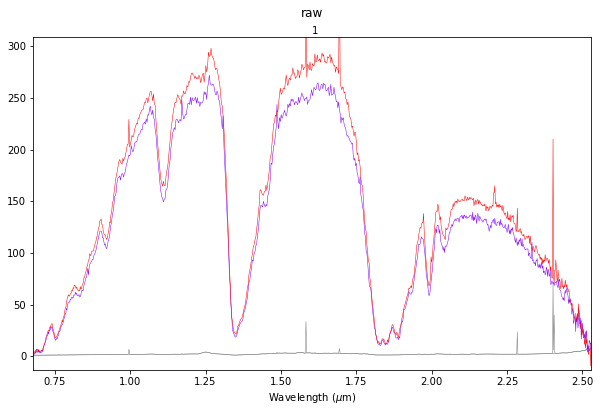

Scaling the spectra...


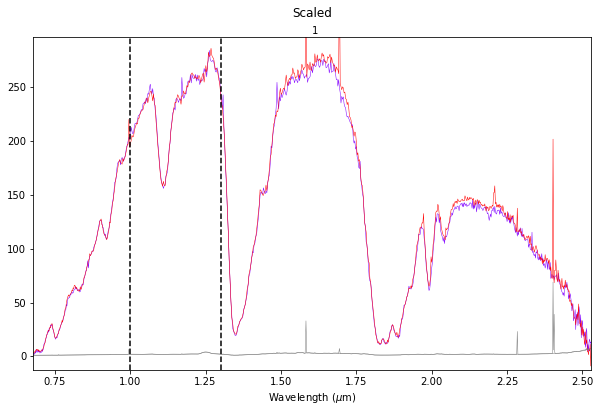

Combining spectra...
Writing spectra to disk...
Wrote combspec1-2.fits.fits to disk.


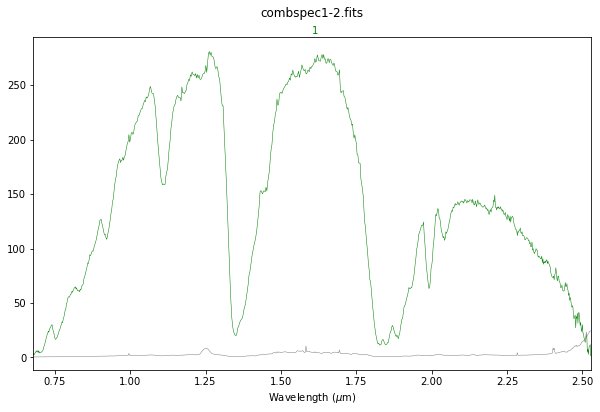

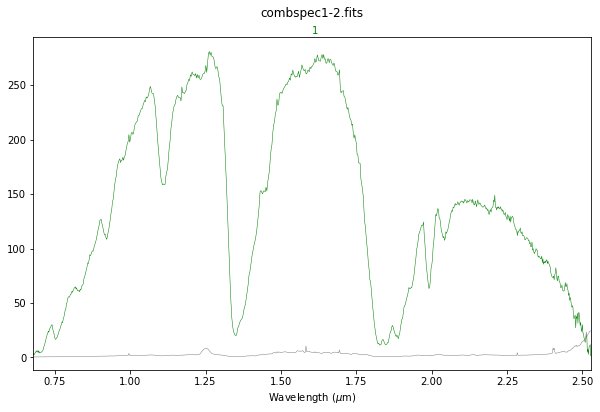

Wrote combspec1-2.pdf to disk.
Combining Spectra
-----------------
Loading spectra...


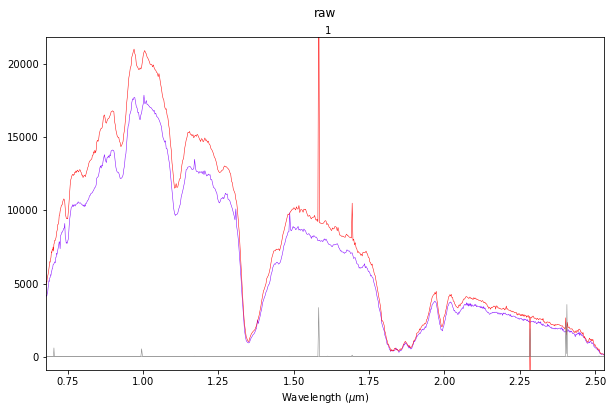

Scaling the spectra...


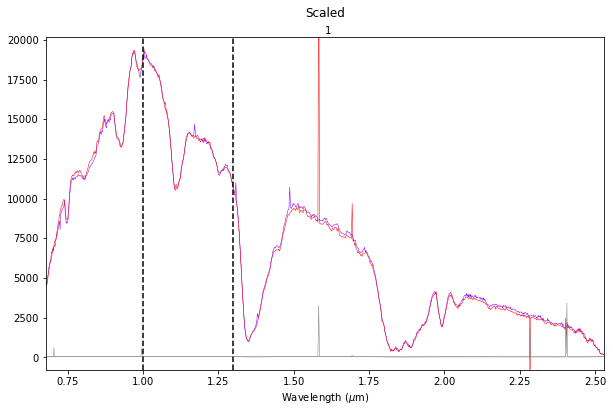

Combining spectra...
Writing spectra to disk...
Wrote combspec7-8.fits.fits to disk.


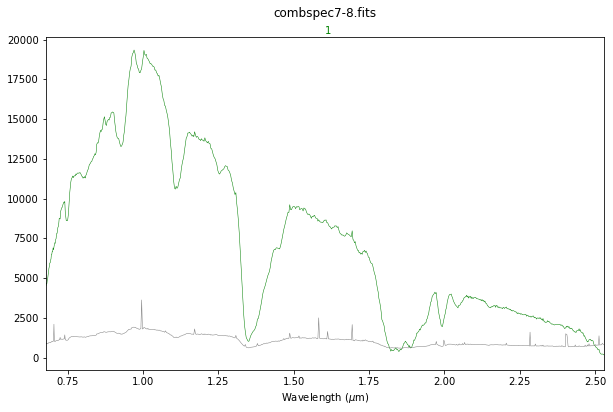

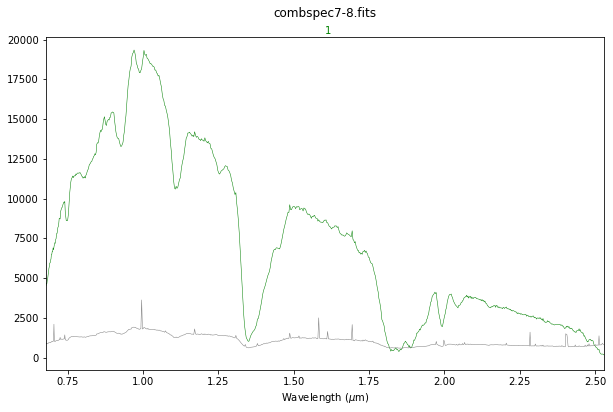

Wrote combspec7-8.pdf to disk.


In [6]:
# source
ps.combine.combine_spectra(['spectra',src_files],'{}{}'.format(combine_prefix,src_files),\
      scale_spectra=True,scale_range=scale_range,correct_spectral_shape=False,qa_plot=True,qa_file=True,verbose=True)

# telluric star
ps.combine.combine_spectra(['spectra',tell_files],'{}{}'.format(combine_prefix,tell_files),\
      scale_spectra=True,scale_range=scale_range,correct_spectral_shape=True,qa_plot=True,qa_file=True,verbose=True)


## Flux calibrate science spectrum with telluric spectrum

[This has not been completed yet]

# Checking your outputs

You should find several output files in your cals and proc folders that allow you to visualize the calibrations and extractions. In addition, you can read in the spectrum and visualize it with plot_spectra.py


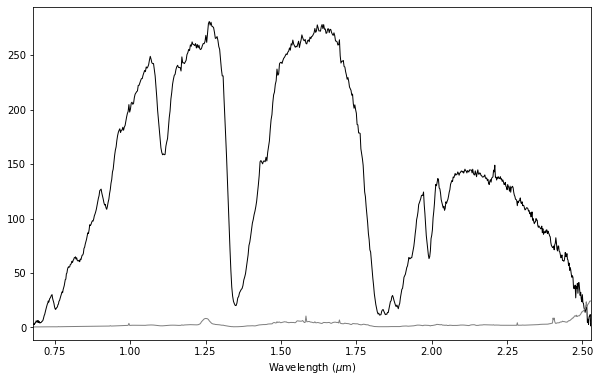

In [7]:
# plot with default parameters
from pyspextool.plot.plot_spectra import plot_spectra

file = 'combspec1-2.fits'
ax = plot_spectra(proc_path+file,colors='k',y="flux and uncertainty",order_numbers=False)

In [8]:
# plot with some modifications
# NOTE: not sure what to do with ax object
file = 'combspec1-2.fits'
ax = plot_spectra(proc_path+file,colors='k',y="flux and uncertainty",order_numbers=False,display=False)
ax.set_xlabel('Wavelength (micron)', fontsize=15)
ax.set_ylabel('F$_{\lambda}$', fontsize=15)
ax.legend(['Flux','Uncertainty'],fontsize=14)
